# Data Mining and Machine Learning - Team Tissot 
## Ensemble Voting Classifier with TfidfVectorizer and with Word2Vec


***Detecting the difficulty level of French texts***

In this notebook we attempted to achieve greater accuracy by using the Ensemble Voting Classifier with TfidfVectorizer and then with Word2Vec.

**Plan :**

1. Importing necessary packages, functions and the data

2. Ensemble models with TfidfVector

3. Ensemble model with Word2Vec

4. Discussion and conclusion

5. Youtube video

# 1. Importing necessary packages, functions and the data


In [ ]:
# Download and update spaCy
!pip install -U spacy

# Download and update the french language model
!python -m spacy download fr

# Download and update mlrose (for the ensemble model)
!pip install mlrose

In [ ]:
# Import required packages
%matplotlib inline
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style("whitegrid")
import string
import gensim
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

# Import required packages
import spacy
from spacy import displacy

# Load French language model
sp = spacy.load("fr_core_news_sm")

# Import and load the required packages for the Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Import some additional packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from google.colab import files

> Import our custom functions from our github report

In [ ]:
!pip install requests
import requests

url = "https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/code/custom_functions.py"
r = requests.get(url)

# Make sure your filename is the same as how you want to import 
with open('custom_functions.py', 'w') as f:
    f.write(r.text)

# Now we can import
import custom_functions as cfun

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


> Loading the data and setting "id" as the index column

In [ ]:
# Training data:
dfTrain = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/training_data.csv", index_col='id')

# Unlabeled test data:
dfTest = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/unlabelled_test_data.csv", index_col='id')

> Split the dataset of dfTrain to train and test our models
>
>*   80% to train
>*   20% to test

In [ ]:
X = dfTrain["sentence"]
y = dfTrain["difficulty"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# 2. Ensemble models with TfidfVector

## 2.1 An example of an ensemble model with the TfidfVecotizer. 


> First, we define a spacy tokenizer which also convert each word into lowercase. 

In [ ]:
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations
    mytokens = sp(sentence)
    # Convert each token into lowercase
    mytokens = [ word.lower_.strip() for word in mytokens] 
    # Return preprocessed list of tokens
    return mytokens

> The token for the TfidfVector with the spacy tokenizer defined above

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,2)) 

> The 3 models that will be used in the ensemble classifier :
>
> 1.   Logistic Regression (logclf)
> 2.   Decision Tree Classifier (dtclf)
> 3.   K-Nearest Neighbors (knnclf)


In [ ]:
# Import some the packages of all the models that we will use here
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Set up the classifiers with some parameters
logclf = LogisticRegression(C=10, max_iter=20000, random_state=0)
dtclf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
knnclf = KNeighborsClassifier()

> The EnsembleVoteClassifier with the 3 models 
 
The parameters :
* clfs = list of classifiers (logclf, dtclf, knnclf)
* weights = [2, 1.5, 1] (2 for the logclf, 1.5 for the dtclf, 1 for the knnclf)

*The others parameters are set with the defaults values (like voting='hard'. The model predicts the class labels (A1,...C2) with the majority rule voting).*

In [ ]:
# Import the package for the Ensemble
from mlxtend.classifier import EnsembleVoteClassifier

# Set up the ensemble classifier
clf_ens = EnsembleVoteClassifier(clfs=[logclf, dtclf, knnclf], weights=[2, 1.5, 1])

# Vectorizer and train the dataset (X_train)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', clf_ens)])

# Train the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7f054e039b80>)),
                ('classifier',
                 EnsembleVoteClassifier(clfs=[LogisticRegression(C=10,
                                                                 max_iter=20000,
                                                                 random_state=0),
                                              DecisionTreeClassifier(criterion='entropy',
                                                                     max_depth=3,
                                                                     random_state=0),
                                              KNeighborsClassifier()],
                                        weights=[2, 1.5, 1]))])

> Evaluate the fitted model

In [ ]:
# Predict the y of the X_test dataset
y_pred = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.45,0.4625,0.45,0.4357


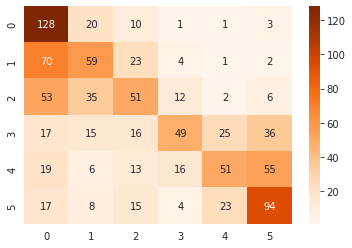

In [ ]:
cfun.evaluate(y_test, y_pred)

As we can see, the accuracy of this model is only 0.45, which is not a significant improvement. When compared to the basic Logistic Regression with the same parameters, this model has lower accuracy, precision, recall, and f1 score.

Examining the diagonal of the confusion matrix, we observe that similarly to other models we tried, the A1 (top-left cell) and the C2 (bottom-right cell) are the most-predicted levels. Finally, by looking at the left column, we can see that there is a problem with this ensemble because a lot of sentences are misclassified as A1. 

> Submit the model to see the final score.

In [ ]:
# Submit the model train with X_train (the train part of dfTrain)
predDifficulty = pipe.predict(dfTest['sentence'])

cfun.prediction(predDifficulty, 'Ensemble_tfidf_example')

,difficulty
id,
0,C2
1,B1
2,A1
3,B1
4,C2


The score of the submission is 0.4458. 

It is a bit lower, but still close to the accuracy computed with the test dataset from dfTrain.


## 2.2 The best model found with the TfidfVectorizer

>We use the same tokenizer that will also lowercase all the words.  

In [ ]:
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)
    # Convert each token into lowercase
    mytokens = [ word.lower_.strip() for word in mytokens ] 
    # Return preprocessed list of tokens
    return mytokens

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,2)) 

> The 3 models that will be used in this ensemble classifier :
>
> 1.   Logistic Regression (logclf)
> 2.   Multi-layer Perceptron classifier (mlpclf)
> 3.   Decision Tree Classifier (dtclf)

In [ ]:
# Import some the packages of all the models that we will use here
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
logclf = LogisticRegression(max_iter=5000, random_state=0)
mlpclf = MLPClassifier(max_iter=1000, random_state=0)
rfclf = RandomForestClassifier(n_estimators=350, random_state=0)

> EnsembleVoteClassifier with the 3 models 
 
The parameters :
* clf = list of classifiers (logclf, mlpclf, rfclf)
* weights = [1.5, 2, 1.5] (1.5 for the Logistic Regression, 2 for the MLP and 1.5 for the Random Forest) 

*The others parameters set with the defaults values.*

In [ ]:
# Set up the ensemble classifier
clf_ens = EnsembleVoteClassifier(clfs=[logclf, mlpclf, rfclf], weights=[1.5, 2, 1.5])

# Vectorizer and train the dataset (X_train)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', clf_ens)])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7f0549f44ee0>)),
                ('classifier',
                 EnsembleVoteClassifier(clfs=[LogisticRegression(max_iter=5000,
                                                                 random_state=0),
                                              MLPClassifier(max_iter=1000,
                                                            random_state=0),
                                              RandomForestClassifier(n_estimators=350,
                                                                     random_state=0)],
                                        weights=[1.5, 2, 1.5]))])

> Evaluate the fitted model

In [ ]:
# Predict the y of the X_test dataset
y_pred = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.4812,0.4809,0.4812,0.4736


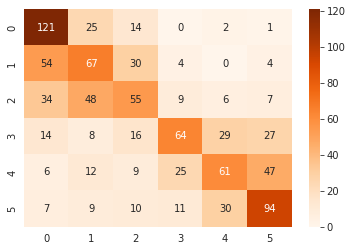

In [ ]:
# Evaluate the model (confusion matrix)
cfun.evaluate(y_test, y_pred)

To improve the model, we used other models with better parameters. The accuracy has increased and is now close to 0.48 for all the metrics. 

The confusion matrix also shows that more sentences have been correcly predicted by the model and there are fewer instances of significant misclassification (e.g., predicting A1, but the correct label is C2).

> Submit the model to see the final score.

In [ ]:
# Submit the model train with X_train (the train part of dfTrain)
predDifficulty = pipe.predict(dfTest['sentence'])

cfun.prediction(predDifficulty, 'Ensemble_tfidf')

,difficulty
id,
0,C2
1,B1
2,A1
3,A1
4,C2


The score of the submission is 0.4675.

It's lower than accuracy that we have with the test dataset from dfTrain. However, it still is an improvement over the first ensemble classifer. The accuracy has increased from 0.446 to 0.468, representing an improvement of almost 2 percentage points.

# 3. Ensemble models with Word2Vec

## 3.1 Set up the base for the model

### 3.1.1 Cleaning and tokenizing the sentences

> First, let's clean the sentences by removing the stop words and the punctuation, and also lowercase all the words.

In [ ]:
# Set the list of stop words and punctuation
stop_words = spacy.lang.fr.stop_words.STOP_WORDS
punctuations = string.punctuation

> We gather some additional information about the sentences using our [custom function](https://github.com/danieldovale/DMML2022_Tissot/blob/main/documents/CustomFunctionsDocumentation.ipynb) get_info().

In [ ]:
# Get all the information about the dataset dfTrain
dfTrainInfo = cfun.get_info(dfTrain)

100%|██████████| 4800/4800 [00:42<00:00, 113.69it/s]



> Next, we define a spacy tokenizer which also cleans the data by lowercasing and lemmatizing all the words. 

In [ ]:
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ] 
    
    # Return preprocessed list of tokens
    return mytokens

> Tokenizing every words in dfTrain and dfTest to feed it as vocabulary to Word2Vec.

In [ ]:
# Tokenize texts from the dataset dfTrain
processed_texts = []
for text in tqdm(dfTrain["sentence"]):
  processed_text = spacy_tokenizer(text)
  processed_texts.append(processed_text)

100%|██████████| 4800/4800 [00:30<00:00, 156.03it/s]


In [ ]:
# Tokenize texts from the dataset dfTest
processed_texts_test = []
for text in tqdm(dfTest["sentence"]):
  processed_text_test = spacy_tokenizer(text)
  processed_texts_test.append(processed_text_test)

100%|██████████| 1200/1200 [00:07<00:00, 158.32it/s]


In [ ]:
# After Tokenize both dataset, we join the two processed dataset. 
processed_texts_both = processed_texts + processed_texts_test

### 3.1.2 Vectorize with Word2Vec

In [ ]:
# Necessary function to set a fixed random state to Word2Vec
def hash(astring):
   return ord(astring[0])

In [ ]:
# Building Word2Vec model
model = gensim.models.Word2Vec(size=512, window=50, min_count=1, workers=1, seed = 0, hashfxn=hash)
model.build_vocab(processed_texts_both)

# Train model on preprocessed sentences
model.train(processed_texts_both, total_examples=len(processed_texts_both), epochs=100)

(8323807, 12880800)

>Building dataframe with vectors

In [ ]:
# Applying Word2Vec vectorizer to every sentence in dfTrain
# Note that the result of the each token is divided by the len of the sentence.
vectors = []
for sent in tqdm(processed_texts):
      vectors.append(sum(model[token] for token in sent)/len(sent))

  0%|          | 0/4800 [00:00<?, ?it/s]<ipython-input-30-0ee4a6e1c4bd>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors.append(sum(model[token] for token in sent)/len(sent))
100%|██████████| 4800/4800 [00:00<00:00, 9795.64it/s]


In [ ]:
# Create a dataframe with all the vectors
dfVectors = pd.DataFrame(vectors)

# Concatenating vectors and info dataframes
dfFinal = pd.concat([dfVectors, dfTrainInfo], axis = 1)

> Split the processed sentences to train the model and test it. 
>
>*   80% to train
>*   20% to test

In [ ]:
X = dfFinal
y = dfTrain['difficulty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 3.2 The Ensemble with Word2Vec 

#### 3.2.1 An simple example of an Ensemble with Word2Vec

> The 3 models that will be used in the ensemble classifier :
>
> 1.   Logistic Regression (logclf)
> 2.   Decision Tree Classifier (dtclf)
> 3.   Linear Support Vector Classifier (svcclf)

In [ ]:
# Import some additional packages 
from sklearn.svm import LinearSVC

# Set up the classifiers with some parameters
logclf = LogisticRegression(C=10, max_iter=15000, random_state=0)
dtclf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
svcclf = LinearSVC(max_iter=2000, tol=0.001, random_state=0)

> The EnsembleVoteClassifier with the 3 classifiers 
 
The parameters :
* clf = list of classifiers (logclf, dtclf, svcclf)
* weights = [2, 1.5, 1] (2 for the logclf, 1.5 for the dtclf, 1 for the svcclf)

*The others parameters set with the defaults values (like voting='hard', it predicts the class labels (A1,...C2) with the majority rule voting).*

In [ ]:
# Set up the ensemble classifier
clf_ens = EnsembleVoteClassifier(clfs=[logclf, dtclf, svcclf],weights=[2,1.5,1])

# Train the model
clf_ens.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


EnsembleVoteClassifier(clfs=[LogisticRegression(C=10, max_iter=15000,
                                                random_state=0),
                             DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=3,
                                                    random_state=0),
                             LinearSVC(max_iter=2000, random_state=0,
                                       tol=0.001)],
                       weights=[2, 1.5, 1])

> Evaluate the fitted model

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,accuracy,precision,recall,f1 score
results,0.4385,0.4842,0.4385,0.4338


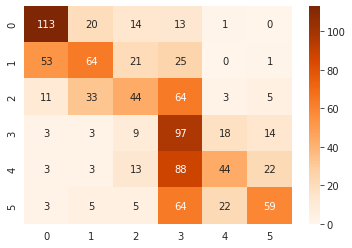

In [ ]:
# Predict the y of the X_test dataset
y_pred = clf_ens.predict(X_test)

# Evaluate the prediction
cfun.evaluate(y_test, y_pred)

For this example, we randomly selected 3 classifiers that we had previously tested individually. We found that the combination of logistic regression, decision tree, and linear SVC resulted in a less accurate model overall.

Analysing the confusion matrix, we can see that there are a lot of misclassified sentences. In addition, we can see that there is a problem, because most of the sentence are misclassified as B2.

> Submit the model to see the final score.

In [ ]:
# Vectorize the dfTest to predict the values with the train model
vectors_test = []
for sent in processed_texts_test:
    vectors_test.append(sum(model[token] for token in sent)/len(sent))

dfVectorsTest = pd.DataFrame(vectors_test)
dfTestInfo = cfun.get_info(dfTest)
dfFinalTest = pd.concat([dfVectorsTest, dfTestInfo], axis = 1)

<ipython-input-36-e305cfd863fa>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors_test.append(sum(model[token] for token in sent)/len(sent))
100%|██████████| 1200/1200 [00:09<00:00, 123.86it/s]


In [ ]:
# Submit the model train with X_train (the train part of dfTrain)
predDifficulty = clf_ens.predict(dfFinalTest)

cfun.prediction(predDifficulty, 'Ensemble_w2v_example_1')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,difficulty
id,
0,C2
1,A2
2,B2
3,B2
4,C2


In [ ]:
# Submit the model train on the whole dfTrain
clf_ens.fit(X, y)

predDifficulty = clf_ens.predict(dfFinalTest)

cfun.prediction(predDifficulty, 'Ensemble_w2v_example_2')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support 

,difficulty
id,
0,C2
1,A2
2,B1
3,B1
4,C2


Score of the submissions : 

*   Train on the split dfTrain (X_train) : 0.425
*   Train on the whole dfTrain : 0.47416

Despite having a lower accuracy with Word2Vec than with TfidfVector for the test dataset of dfTrain, the model performed better when making predictions on unseen data. Which was a bit surprising, however the results are not as promising as we had hoped.

#### 3.2.2 The best model found with an Ensemble Classifier and Word2Vec

> The 3 models that will be used in the ensemble classifier :
>
> 1.   Logistic Regression (logclf)
> 2.   Random Forest Classifier (rfclf)
> 3.   Multi-layer Perceptron classifier (mlpclf)


In [ ]:
# Set up the classifiers with some parameters
logclf = LogisticRegression(C = 10, max_iter = 20000, random_state = 0)
mlpclf = MLPClassifier(max_iter=1000, random_state=0)
rfclf = RandomForestClassifier(n_estimators=350, random_state=0)

> The EnsembleVoteClassifier with the 3 models 
 
The parameters :
* clf = list of classifiers (logclf, rfclf, mlpclf)
* weights = [1.5, 1, 1] (1.5 for the logclf, 1 for the mlpclf, 1 for the rfclf)

*The others parameters are set with the defaults values (like voting='hard', it predicts the class labels (A1,...C2) with the majority rule voting).*

In [ ]:
# Set up the ensemble classifier
clf_ens = EnsembleVoteClassifier(clfs=[logclf, mlpclf, rfclf],weights=[1.5,1,1])

# Train the model
clf_ens.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


EnsembleVoteClassifier(clfs=[LogisticRegression(C=10, max_iter=20000,
                                                random_state=0),
                             MLPClassifier(max_iter=1000, random_state=0),
                             RandomForestClassifier(n_estimators=350,
                                                    random_state=0)],
                       weights=[1.5, 1, 1])

> Evaluate the fitted model

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,accuracy,precision,recall,f1 score
results,0.5135,0.5169,0.5135,0.5121


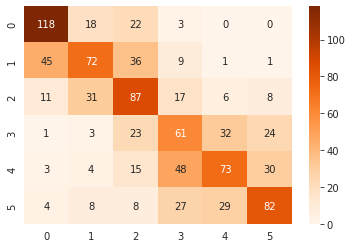

In [ ]:
# Predict the y of the X_test dataset
y_pred = clf_ens.predict(X_test)

# Evaluate the prediction
cfun.evaluate(y_test, y_pred)

This model surpassed the threshold of 0.5 for all evaluation metrics. With a score close to 0.51, this is the one of the best model that we have found for predicting the class of each sentence. In addition, we can note that we have similar results to the metrics found in the Word2Vec with a simple Logistic Regression model. 

Analysing the confusion matrix, we can see that some sentences are still completely misclassified. However, the error of classification is lower, as more and more sentences are closer to the correct class.

> Submit the model to see the final score.

In [ ]:
# Vectorize the dfTest to predict the values with the train model
vectors_test = []
for sent in processed_texts_test:
    vectors_test.append(sum(model[token] for token in sent)/len(sent))

dfVectorsTest = pd.DataFrame(vectors_test)
dfTestInfo = cfun.get_info(dfTest)
dfFinalTest = pd.concat([dfVectorsTest, dfTestInfo], axis = 1)

<ipython-input-42-e305cfd863fa>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors_test.append(sum(model[token] for token in sent)/len(sent))
100%|██████████| 1200/1200 [00:09<00:00, 122.70it/s]


In [ ]:
# Submit the model train with X_train (the train part of dfTrain)
predDifficulty = clf_ens.predict(dfFinalTest)

cfun.prediction(predDifficulty, 'Ensemble_w2v_best_1')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,difficulty
id,
0,C2
1,A2
2,B1
3,B1
4,C2


In [ ]:
# Submit the model train on the whole dfTrain
clf_ens.fit(X, y)

predDifficulty = clf_ens.predict(dfFinalTest)

cfun.prediction(predDifficulty, 'ensemble_w2v_best_2')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

,difficulty
id,
0,A2
1,A2
2,B1
3,B1
4,C2


Score of the submissions : 


*   Train on the split dfTrain (X_train) : 0.485
*   Train on the whole dfTrain : 0.49166

# 4. Discussion and conclusion

|       | Example Ensemble (Tfidf) | Better Ensemble (Tfidf) |  Example Ensemble (W2V) | Better Ensemble (W2V) 
| :---       |   :----:   |  :----: |  :----:   |  :----: |
| *Precision*| 0.4625 | 0.4812 | 0.4385 | 0.5135 |
| *Recall*   | 0.45 | 0.4809 | 0.4842 | 0.5169 |
| *F1-score* | 0.4357 | 0.4812 | 0.4385 | 0.5135 |
| *Accuracy* | 0.45 | 0.4736 | 0.4338 | 0.5121 |
| Submission Score (X_test)| *0.4458* | *0.4675* | *0.425* | *0.485*|
| Submission Score (dfTrain)| *-* | *-* | *0.47416* | *0.49166*|

**Eureka !**

We finally obtained a score above 0.49 in the submission. As said in the analysis of the confusion matrix, we have another model that uses Word2Vec vectorization with Logistic Regression with hyperparameters and has a similar level of accuracy. However, when predicting sentences for submission, this Logistic Regression model has significantly lower accuracy, with a score of 0.464 compared to our score of 0.491. This suggests that the Logistic Regression model with Word2Vec had a significant issue with overfitting.

So one of the solution in case of overfitting is to use an ensemble method. We started by testing the ensemble with the Tfidf vectorizer and got some interesting results. Then, we tried with the Word2Vec vectorizer and with a combination of different classifiers such as Decision Tree, Linear SVC and K-Nearest Neighbors. Additionally, we tried to improve the predictions by removing stopwords, numbers, and punctuations, but this actually decreased the quality of the predictions.

After testing a variety of classifiers with different parameters, we found this combination that had a score of 0.49166 when predicting the level of each sentence. This indicates that the model predicts correctly the level at the probability of almost 50%. And it seems that it partially solves the overfitting issue. 

In addition, we believe that the Ensemble model with Word2Vec can still be slightly improved with further fine-tuning. However, there are other, more effective models such as Bert or camemBert that are pretrained and could potentially achieve a higher prediction accuracy.


In conclusion, it would have been more effective to carefully analyze the data and thoroughly review the documentation for different models before attempting to use them for our project. Our mistake was just throwing different models with various tokenization and vectorization techniques without fully understanding their implications. This didn’t work out too well since our best model only showed a slight improvement of 3% compared to our initial logistic regression model. To improve the success of future projects, it would be important to take the time to thoroughly evaluate and understand the data and available models before proceeding.


# Youtube video

Here is our [youtube video](https://youtu.be/X2feNkp1Vik), where we explain what we have done in this project.  

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('https://youtu.be/X2feNkp1Vik')